In [56]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.signal import find_peaks, periodogram
from scipy.ndimage import gaussian_filter1d
import gpytorch
import torch

from dipper.data_utils.utils import *
from dipper.model_utils.gp_model import train_gp
from dipper.model_utils.utils import check_identified_anomalies

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Grid search for each lightcurve
Iterate over every possible anomalous interval (from nyquist frequency to 10% of lightcurve) in lightcurve, and train GP on data without this interval.
Choose  most likely interval using the lowest metric.

In [57]:
lightcurve_numbers = [17, 18, 27, 28, 44, 3, 9, 29, 43, 48, 70]
period_scales=[0.001, 0.003, 0.007, 0.017, 0.044, 0.114, 0.293, 0.755, 1.945, 5.012]
snrs=[5.0, 4.0, 3.0, 2.0, 1.0]
PERIODIC_LC = [3, 9, 29, 43, 48, 70]
FLAT_LC = [17, 18, 27, 28, 44]
results_dir = "../results/"
data_dir = "grid_search_min_likelihood_on_interval" + "/"

# Create empty dictionary to store a min likleihood interval for each lightcruve, period_scale, and snr
min_likelihood_intervals = {}
cols = ["lightcurve", "period_scale", "snr", "start", "end", "anomaly_idx", "identified"]

# Loop over all lightcurves, period_scales, and snrs to find the min likelihood interval
for lc in lightcurve_numbers:
    for ps in period_scales:
        for snr in snrs:
            data_name = f"file_{lc}_snr_{snr}_period_{ps}.txt"
            data = pd.read_csv(results_dir + data_dir + data_name, header=0, sep=",")
            
            # find the best metric start and end interval
            best_metric = data["metric"].min()
            best_interval = data[data["metric"] == best_metric]
            start = int(best_interval["start"].values[0])
            end = int(best_interval["end"].values[0])
            
            # store the best interval
            min_likelihood_intervals[(lc, ps, snr)] = (start, end)

            # Load the data
            lc_dir = '../data/k2/'
            filename = f'k2_{lc}.fits'
            x, y, y_err = load_k2_data(lc_dir + filename)

            # Scale data to be between 0 and 1
            y = (y - np.min(y)) / (np.max(y) - np.min(y))
            y_err = y_err / (np.max(y) - np.min(y))

            # Inject anomalies
            steps, y, anomaly_locs, anomaly_amp, anomaly_fwhm = inject_anomaly(
                y, 
                num_anomalies=1, 
                seed=lc, 
                shapes=["gaussian"],
                period_scale=ps,
                snr=snr,
            )

            # Check if the identified anomalies are correct
            detection_range = 50
            min_contiguous = 10
            anomalous = np.zeros_like(y)
            anomalous[start:end] = 1
            identified_anomalies = check_identified_anomalies(
                anomaly_locs=anomaly_locs,
                anomalous=anomalous,
                detection_range=detection_range,
                min_contiguous=min_contiguous,
            )
            
            # Store the results
            min_likelihood_intervals[(lc, ps, snr)] = (start, end, anomaly_locs[0], identified_anomalies[0][0])

df = pd.DataFrame(min_likelihood_intervals).T.reset_index()
df.columns = cols
df.to_csv(results_dir + data_dir + "min_likelihood_intervals.csv", index=False)

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/

### Periodic plot

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/

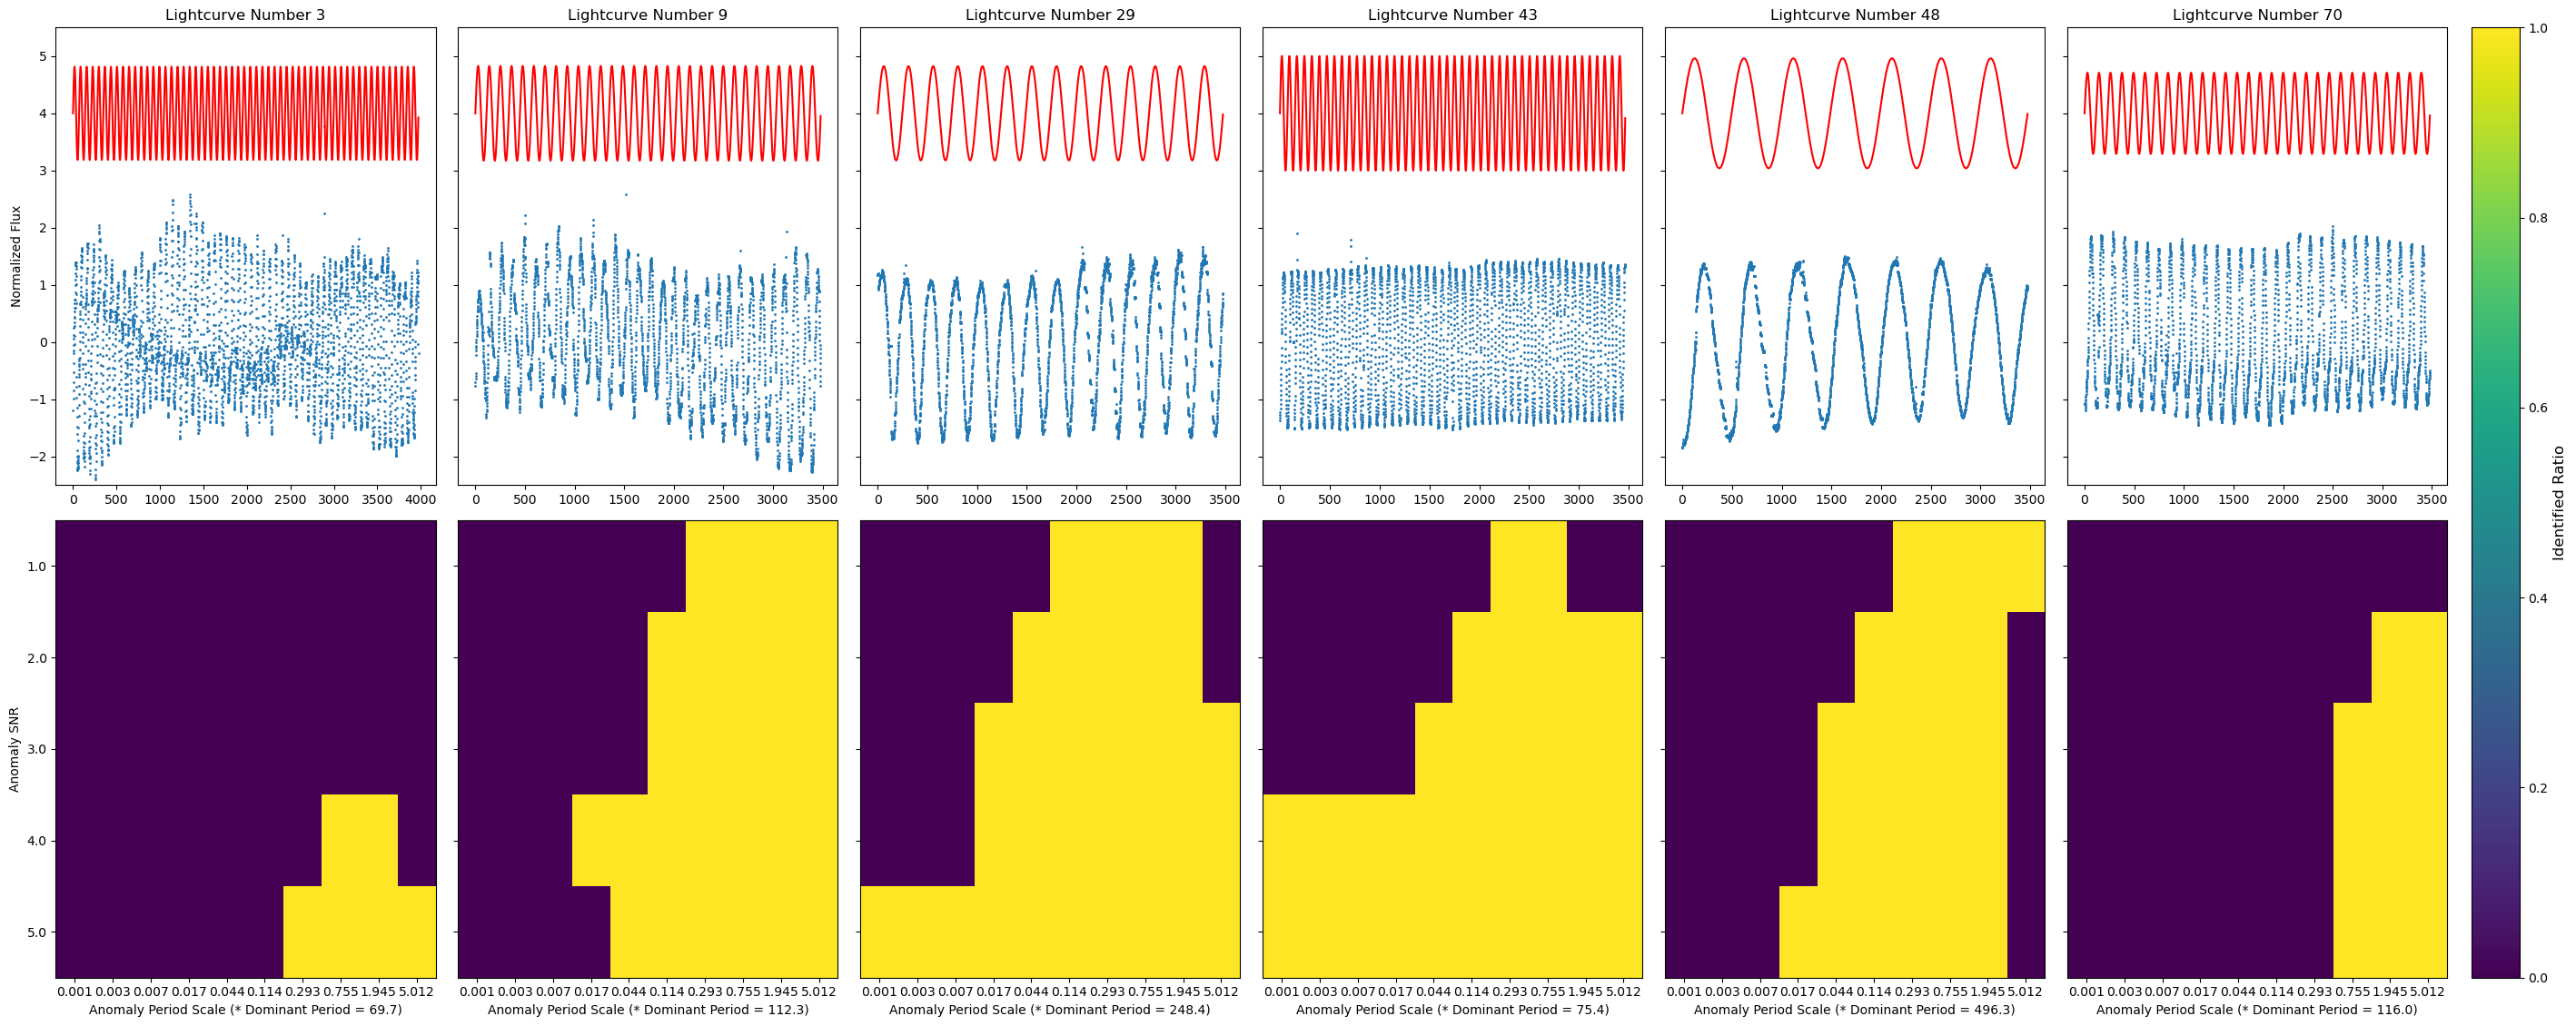

In [58]:
# Create figure
fig, axs = plt.subplots(2, 6, figsize=(28, 12))
for ax in axs.flat:
    ax.label_outer()

# Colorbar placeholder
im = None

# Colorbar min and max
vmin = df['identified'].min()
vmax = df['identified'].max()

# Plot each filename and location
for i, lc in enumerate(PERIODIC_LC):
    # Filter to only the current filename and label with filename
    filename_grouped = df[df['lightcurve'] == lc]

    # Load the associated lightcurve
    k2_data_dir = '../data/k2/'
    k2_data_filename = f'k2_{lc}.fits'
    x, y, y_err = load_k2_data(k2_data_dir + k2_data_filename)

    # Create column that converts period_scale to actual value (multiply by the dominant period)
    freqs, power = periodogram(y)
    peaks, _ = find_peaks(power)
    if len(peaks) == 0:
        print("No peaks found in power spectrum, using shoulder instead")
        smooth_power = gaussian_filter1d(power, 2)
        slope = np.gradient(smooth_power, freqs)
        shoulder_idx = np.where(slope < 0)[0][0]
        dominant_period = 1 / freqs[shoulder_idx]
        
    else:
        dominant_peak = peaks[np.argmax(power[peaks])]
        dominant_period = 1 / freqs[dominant_peak]

    # Standardize data to have mean 0 and std of 1
    mean_y = np.mean(y)
    std_y = np.std(y)
    y = (y - mean_y) / std_y
    y_err = y_err / std_y

    # Plot lightcurve in axs[0, i]
    time_steps = np.arange(len(y))
    axs[0, i].plot(time_steps, y, '.', markersize=2, label='Raw Lightcurve (no anomaly injections)')
    axs[0, i].set_title(f"Lightcurve Number {lc}")

    # Above the lightcurve, plot a sinusoidal curve with the dominant period and amplitude 1 SNR
    snr = 1
    noise = np.median(np.abs(y - np.median(y)))
    amp = snr * noise
    y_sin = amp * np.sin(2 * np.pi * time_steps / dominant_period) + 4
    axs[0, i].plot(time_steps, y_sin, color='r', label='Dominant Period Sinusoid with Amplitude 1 SNR')

    # Show x-ticks and labels for every subplot
    axs[0, i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    axs[0, i].set_ylim([-2.5, 5.5])

    # Plot an imshow image colored by identified, x_axis is width_stdev, y_axis is amp
    pivot = filename_grouped.pivot(index='snr', columns='period_scale', values='identified')

    axs[1, i].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    axs[1, i].set_xlabel("Anomaly Period Scale (* Dominant Period = {:.1f})".format(dominant_period))
    axs[1, i].set_xticks(range(len(pivot.columns)), pivot.columns)
    axs[1, i].set_yticks(range(len(pivot.index)), pivot.index)

    if i==0: 
        axs[0, i].set_ylabel("Normalized Flux")
        axs[1, i].set_ylabel("Anomaly SNR")

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add a single colorbar to the right of the subplots for each row
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Identified Ratio', fontsize=12)

# Save and show the figure
plt.savefig(results_dir + data_dir + "/periodic.png", bbox_inches='tight')
plt.show()

### Flat plot

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/

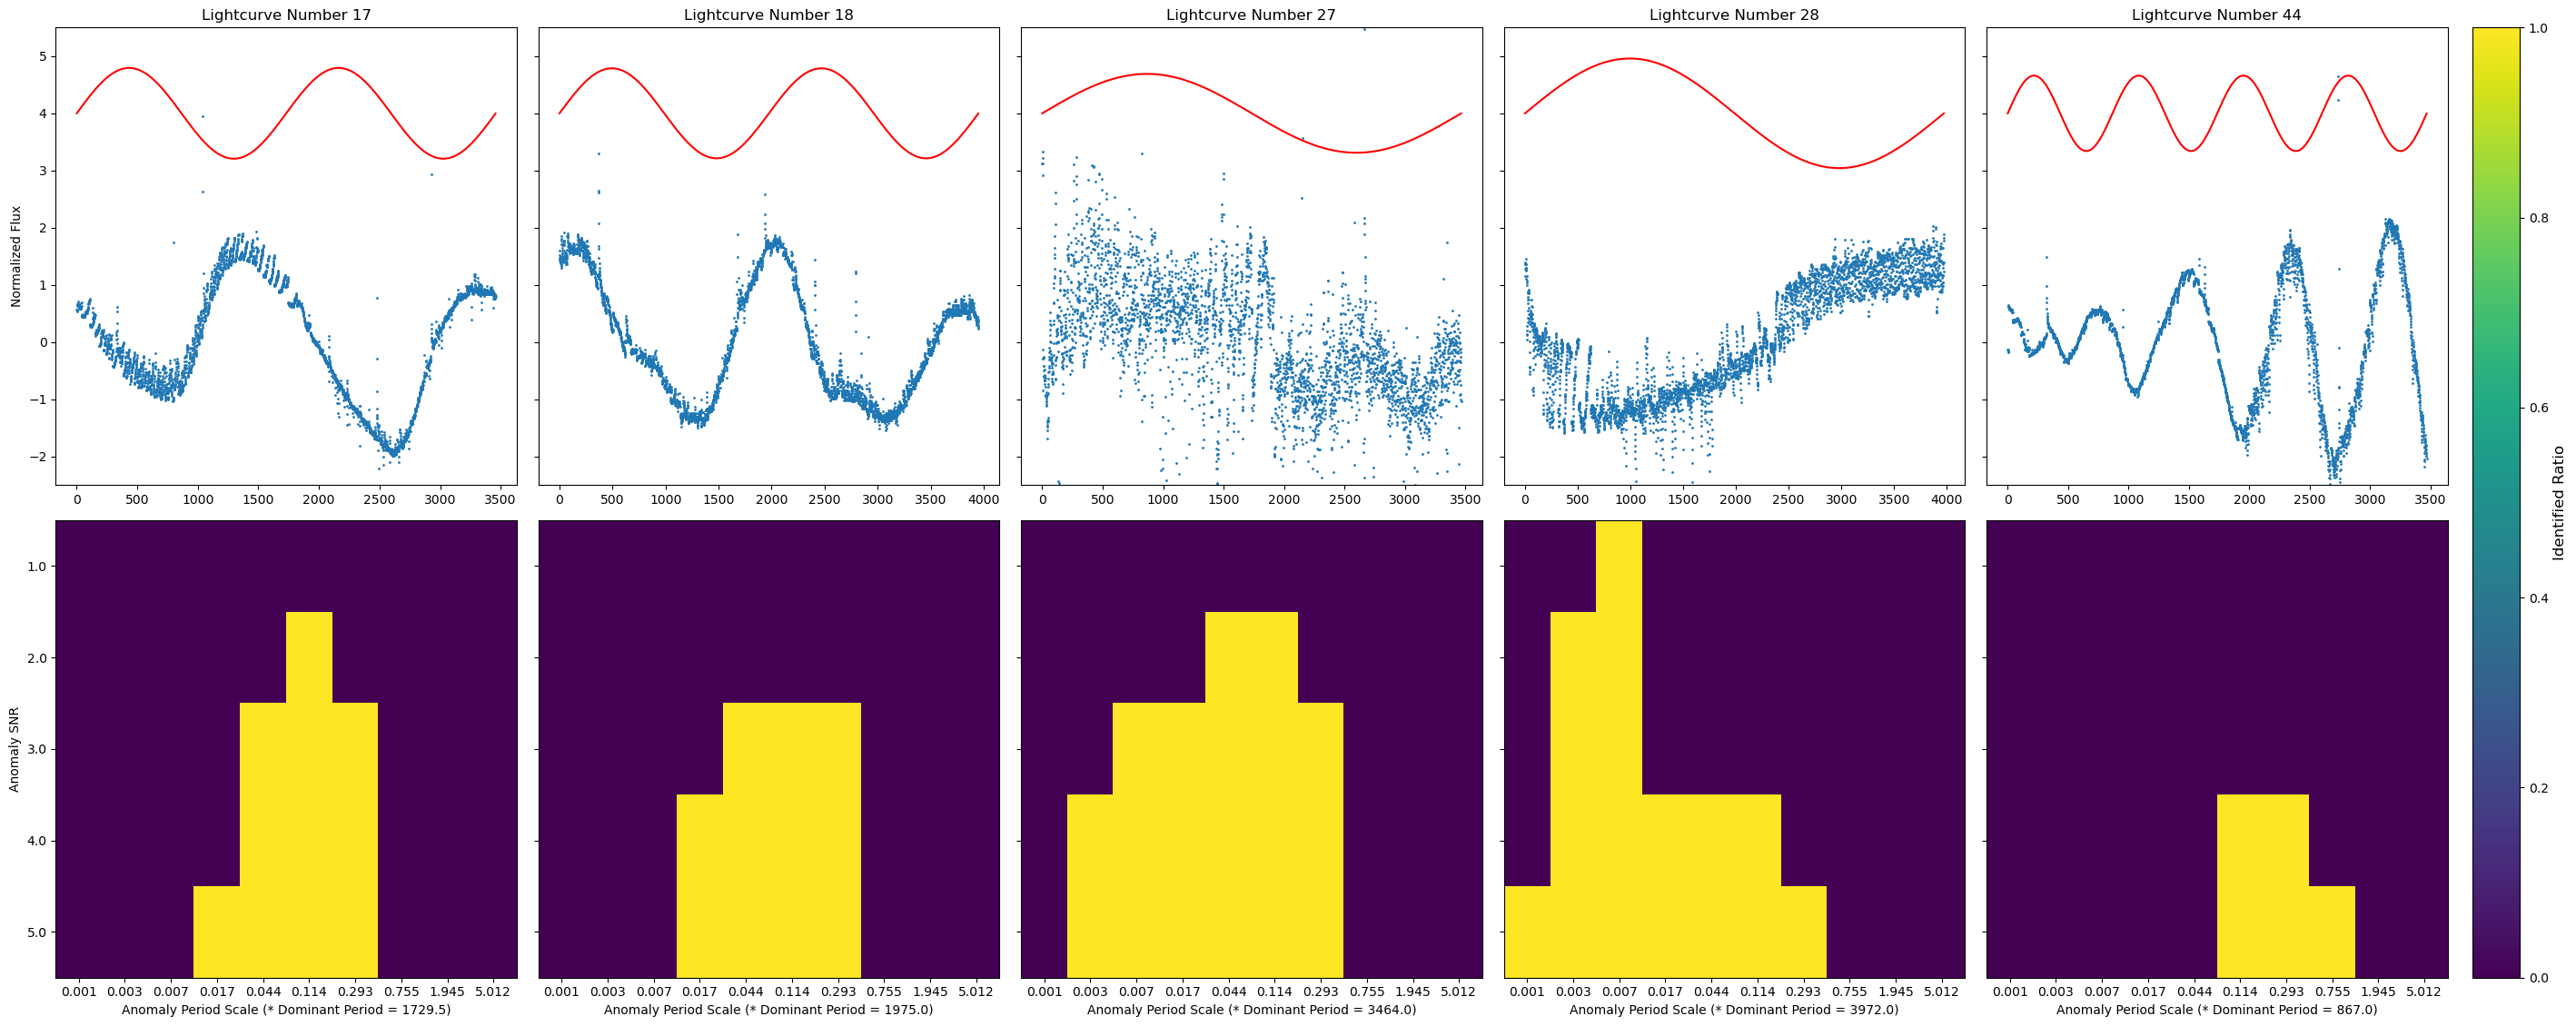

In [59]:
# Create figure
fig, axs = plt.subplots(2, 5, figsize=(28, 12))
for ax in axs.flat:
    ax.label_outer()

# Colorbar placeholder
im = None

# Colorbar min and max
vmin = df['identified'].min()
vmax = df['identified'].max()

# Plot each filename and location
for i, lc in enumerate(FLAT_LC):
    # Filter to only the current filename and label with filename
    filename_grouped = df[df['lightcurve'] == lc]

    # Load the associated lightcurve
    k2_data_dir = '../data/k2/'
    k2_data_filename = f'k2_{lc}.fits'
    x, y, y_err = load_k2_data(k2_data_dir + k2_data_filename)

    # Create column that converts period_scale to actual value (multiply by the dominant period)
    freqs, power = periodogram(y)
    peaks, _ = find_peaks(power)
    if len(peaks) == 0:
        print("No peaks found in power spectrum, using shoulder instead")
        smooth_power = gaussian_filter1d(power, 2)
        slope = np.gradient(smooth_power, freqs)
        shoulder_idx = np.where(slope < 0)[0][0]
        dominant_period = 1 / freqs[shoulder_idx]
        
    else:
        dominant_peak = peaks[np.argmax(power[peaks])]
        dominant_period = 1 / freqs[dominant_peak]

    # Standardize data to have mean 0 and std of 1
    mean_y = np.mean(y)
    std_y = np.std(y)
    y = (y - mean_y) / std_y
    y_err = y_err / std_y

    # Plot lightcurve in axs[0, i]
    time_steps = np.arange(len(y))
    axs[0, i].plot(time_steps, y, '.', markersize=2, label='Raw Lightcurve (no anomaly injections)')
    axs[0, i].set_title(f"Lightcurve Number {lc}")

    # Above the lightcurve, plot a sinusoidal curve with the dominant period and amplitude 1 SNR
    snr = 1
    noise = np.median(np.abs(y - np.median(y)))
    amp = snr * noise
    y_sin = amp * np.sin(2 * np.pi * time_steps / dominant_period) + 4
    axs[0, i].plot(time_steps, y_sin, color='r', label='Dominant Period Sinusoid with Amplitude 1 SNR')

    # Show x-ticks and labels for every subplot
    axs[0, i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    axs[0, i].set_ylim([-2.5, 5.5])

    # Plot an imshow image colored by identified, x_axis is width_stdev, y_axis is amp
    pivot = filename_grouped.pivot(index='snr', columns='period_scale', values='identified')

    axs[1, i].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    axs[1, i].set_xlabel("Anomaly Period Scale (* Dominant Period = {:.1f})".format(dominant_period))
    axs[1, i].set_xticks(range(len(pivot.columns)), pivot.columns)
    axs[1, i].set_yticks(range(len(pivot.index)), pivot.index)

    if i==0: 
        axs[0, i].set_ylabel("Normalized Flux")
        axs[1, i].set_ylabel("Anomaly SNR")

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add a single colorbar to the right of the subplots for each row
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Identified Ratio', fontsize=12)

# Save and show the figure
plt.savefig(results_dir + data_dir + "/flat.png", bbox_inches='tight')
plt.show()

## Varying size for random files and locs
Random injection sites and files with varying anoamly sizes. Create 1x1 plot summarizing 100 repeats for each grid

In [2]:
data_dir = "../results/"
data_name = "gp_vary_size_100_snr" 
# note gp_vary_size_100_repeats_fixed is missing some values for width 24, so remove those

results = pd.read_csv(data_dir + data_name + ".csv")
print(len(results))

# Count for each amp and width_stdev the total number of filenames and locations that were marked as identified = 1.0
grouped = results.groupby(["snr", "period_scale"]).agg(
    num_identified=('identified', 'sum'),
    total_experiments=('identified', 'count')
).reset_index()

grouped["identified_ratio"] = grouped["num_identified"] / grouped["total_experiments"]

# Period_scale to 2 decimal places
grouped["period_scale"] = grouped["period_scale"].apply(lambda x: round(x, 2))

print(len(grouped))
grouped.head()

5000
50


,snr,period_scale,num_identified,total_experiments,identified_ratio
0,1.0,0.10,11.0,100,0.11
1,1.0,0.15,6.0,100,0.06
2,1.0,0.24,13.0,100,0.13
3,1.0,0.37,14.0,100,0.14
4,1.0,0.57,26.0,100,0.26


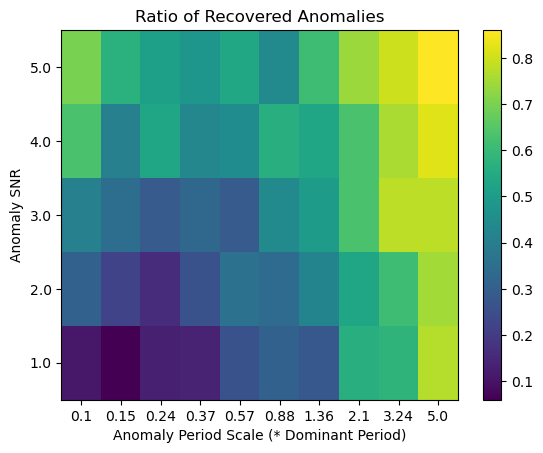

In [3]:
# Plot an imshow image colored by identified_ratio, x_axis is width_stdev, y_axis is amp
pivot = grouped.pivot(index='snr', columns='period_scale', values='identified_ratio')

# Re-index the pivot to have high SNR at the top and low SNR at the bottom
pivot = pivot.reindex(index=pivot.index[::-1])

plt.imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto')
cbar = plt.colorbar()
plt.xlabel("Anomaly Period Scale (* Dominant Period)")
plt.ylabel("Anomaly SNR")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title("Ratio of Recovered Anomalies")
plt.savefig(data_dir + data_name + ".png")
plt.show()

## Varying size and amplitude for single files but random locs analysis
Create a 3x1 plot with above plot for each of the 3 lightcurves

In [5]:
data_dir = "../results/"
data_name = "gp_vary_size_100_repeats_3files_snr" 

results = pd.read_csv(data_dir + data_name + ".csv")
print(len(results))

# Get unique filenames and locations
filenames = results['filename'].unique()
short_filenames = [filename.split('k2_')[1].split('.fits')[0] for filename in filenames]
print(filenames, short_filenames)

# Count for each amp and width_stdev the total number of filenames and locations that were marked as identified = 1.0
grouped = results.groupby(["snr", "period_scale", "filename"]).agg(
    num_identified=('identified', 'sum'),
    total_experiments=('identified', 'count')
).reset_index()

grouped["identified_ratio"] = grouped["num_identified"] / grouped["total_experiments"]

# Period_scale to 2 decimal places
grouped["period_scale"] = grouped["period_scale"].apply(lambda x: round(x, 2))

print(len(grouped))
grouped.head()

14999
['k2_3.fits' 'k2_18.fits' 'k2_48.fits'] ['3', '18', '48']
150


,snr,period_scale,filename,num_identified,total_experiments,identified_ratio
0,1.0,0.10,k2_18.fits,32.0,100,0.320000
1,1.0,0.10,k2_3.fits,3.0,101,0.029703
2,1.0,0.10,k2_48.fits,0.0,100,0.000000
3,1.0,0.15,k2_18.fits,59.0,100,0.590000
4,1.0,0.15,k2_3.fits,2.0,100,0.020000


/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:202: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:202: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:202: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


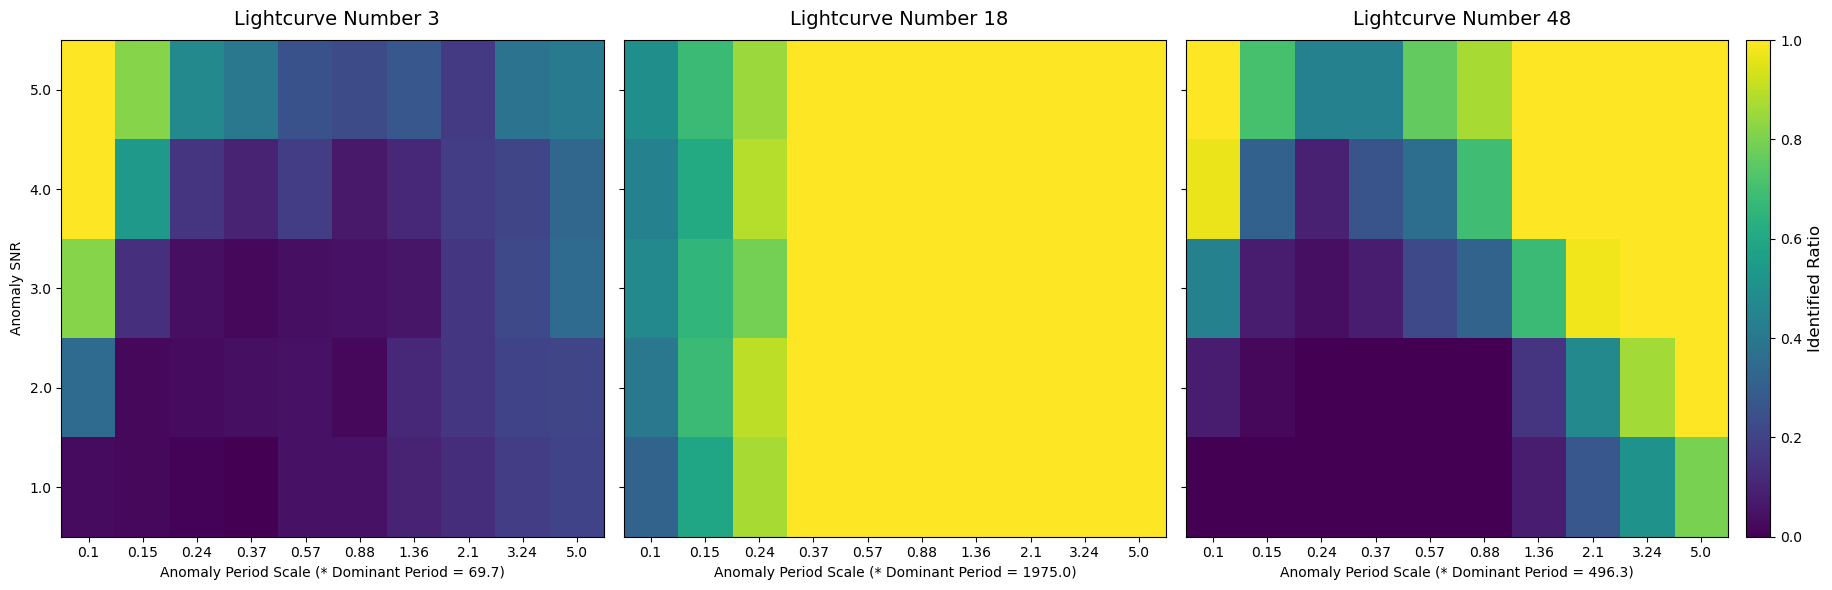

In [9]:
# Create figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# fig.suptitle("Ratio of Recovered Anomalies", fontsize=16)
for ax in axs.flat:
    ax.label_outer()

# Colorbar placeholder
im = None

# Colorbar min and max
vmin = grouped['identified_ratio'].min()
vmax = grouped['identified_ratio'].max()

# Plot each filename and location
for i, filename in enumerate(filenames):
    # Filter to only the current filename and label with filename
    filename_grouped = grouped[grouped['filename'] == filename]
    fig.text(0.19 + i / 3.2, 0.95, f"Lightcurve Number {short_filenames[i]}", ha='center', fontsize=14)

    # Load the associated lightcurve
    k2_data_dir = '../data/k2/'
    filename = f'k2_{short_filenames[i]}.fits'
    x, y, y_err = load_k2_data(k2_data_dir + filename)

    # Scale data to be between 0 and 1
    y = (y - np.min(y)) / (np.max(y) - np.min(y))
    y_err = y_err / (np.max(y) - np.min(y))

    # Create column that converts period_scale to actual value (multiply by the dominant period)
    freqs, power = periodogram(y)
    peaks, _ = find_peaks(power)
    if len(peaks) == 0:
        print("No peaks found in power spectrum, using shoulder instead")
        smooth_power = gaussian_filter1d(power, 2)
        slope = np.gradient(smooth_power, freqs)
        shoulder_idx = np.where(slope < 0)[0][0]
        dominant_period = 1 / freqs[shoulder_idx]
        
    else:
        dominant_peak = peaks[np.argmax(power[peaks])]
        dominant_period = 1 / freqs[dominant_peak]

    # Plot an imshow image colored by identified_ratio, x_axis is width_stdev, y_axis is amp
    pivot = filename_grouped.pivot(index='snr', columns='period_scale', values='identified_ratio')
    
    # Re-index the pivot to have high SNR at the top and low SNR at the bottom
    pivot = pivot.reindex(index=pivot.index[::-1])

    axs[i].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    if i==0: axs[i].set_ylabel("Anomaly SNR")
    axs[i].set_xlabel("Anomaly Period Scale (* Dominant Period = {:.1f})".format(dominant_period))
    axs[i].set_xticks(range(len(pivot.columns)), pivot.columns)
    axs[i].set_yticks(range(len(pivot.index)), pivot.index)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add a single colorbar to the right of the subplots
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Identified Ratio', fontsize=12)

# Save and show the figure
plt.savefig(data_dir + data_name + ".png")
plt.show()

## Varying size and amplitude for single files but random locs analysis, for many flat/periodic lightcurves
Create a large plot of lightcurve above with pivot imshow below each lightcurve, for the flat and periodic lightcurves separately

In [2]:
data_dir = "../results/"
data_name = "gp_periodic_vs_flat_new_detection" 

# Load periodic lc data and flat lc data into separate dataframes
PERIODIC_LC = [3, 9, 29, 43, 48, 70]
FLAT_LC = [17, 18, 27, 28, 44]

for i in PERIODIC_LC:
    curr = pd.read_csv(data_dir + data_name + f"/lc_{i}.csv")

    # Aggregate into big periodic dataframe
    if i == PERIODIC_LC[0]:
        periodic = curr
    else:
        periodic = pd.concat([periodic, curr])

for i in FLAT_LC:
    curr = pd.read_csv(data_dir + data_name + f"/lc_{i}.csv")

    # Aggregate into big flat dataframe
    if i == FLAT_LC[0]:
        flat = curr
    else:
        flat = pd.concat([flat, curr])

# Load whitenoise: data_dir + data_name + "/whitenoise.csv"
whitenoise = pd.read_csv(data_dir + data_name + "/whitenoise.csv")

# Convert the identified column to a int; "[1.0]" = 1, "[0.0]" = 0
periodic["identified"] = periodic["identified"].apply(lambda x: int(x[1]))
flat["identified"] = flat["identified"].apply(lambda x: int(x[1]))
whitenoise["identified"] = whitenoise["identified"].apply(lambda x: int(x[1]))

# Get unique filenames and locations
filenames_periodic = periodic['filename'].unique()
short_filenames_periodic = [filename.split('k2_')[1].split('.fits')[0] for filename in filenames_periodic]

filenames_flat = flat['filename'].unique()
short_filenames_flat = [filename.split('k2_')[1].split('.fits')[0] for filename in filenames_flat]

# Count for each amp and width_stdev the total number of filenames and locations that were marked as identified = 1.0
grouped_periodic = periodic.groupby(["snr", "period_scale", "filename"]).agg(
    num_identified=('identified', 'sum'),
    total_experiments=('identified', 'count')
).reset_index()

grouped_periodic["identified_ratio"] = grouped_periodic["num_identified"] / grouped_periodic["total_experiments"]

grouped_flat = flat.groupby(["snr", "period_scale", "filename"]).agg(
    num_identified=('identified', 'sum'),
    total_experiments=('identified', 'count')
).reset_index()

grouped_flat["identified_ratio"] = grouped_flat["num_identified"] / grouped_flat["total_experiments"]

grouped_whitenoise = whitenoise.groupby(["snr", "period_scale", "filename"]).agg(
    num_identified=('identified', 'sum'),
    total_experiments=('identified', 'count')
).reset_index()

grouped_whitenoise["identified_ratio"] = grouped_whitenoise["num_identified"] / grouped_whitenoise["total_experiments"]

# Period_scale to 2 decimal places
grouped_periodic["period_scale"] = grouped_periodic["period_scale"].apply(lambda x: round(x, 3))
grouped_flat["period_scale"] = grouped_flat["period_scale"].apply(lambda x: round(x, 3))
grouped_whitenoise["period_scale"] = grouped_whitenoise["period_scale"].apply(lambda x: round(x, 3))

print(len(grouped_periodic))
print(len(grouped_flat))
print(len(grouped_whitenoise))

270
225
45


### Whitenoise plot

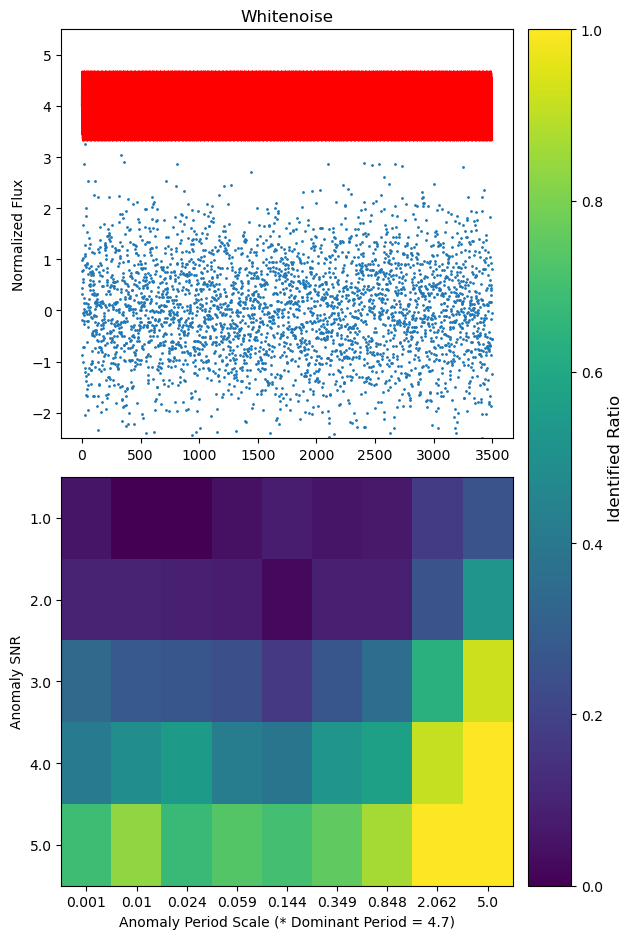

In [3]:
# Create figure
fig, axs = plt.subplots(2, 1, figsize=(6, 10))

# Colorbar placeholder
im = None

# Colorbar min and max
vmin = grouped_whitenoise['identified_ratio'].min()
vmax = grouped_whitenoise['identified_ratio'].max()

# Load the associated lightcurve
k2_data_dir = '../data/'
k2_data_filename = f'whitenoise.fits'
hdu = fits.open('../data/whitenoise.fits')
x = hdu[0].data[0]
y = hdu[0].data[1]
y_err = hdu[0].data[2]

# Convert to native byte order
x = x.byteswap().newbyteorder()
y = y.byteswap().newbyteorder()
y_err = y_err.byteswap().newbyteorder()

# Create column that converts period_scale to actual value (multiply by the dominant period)
freqs, power = periodogram(y)
peaks, _ = find_peaks(power)
if len(peaks) == 0:
    print("No peaks found in power spectrum, using shoulder instead")
    smooth_power = gaussian_filter1d(power, 2)
    slope = np.gradient(smooth_power, freqs)
    shoulder_idx = np.where(slope < 0)[0][0]
    dominant_period = 1 / freqs[shoulder_idx]
    
else:
    dominant_peak = peaks[np.argmax(power[peaks])]
    dominant_period = 1 / freqs[dominant_peak]

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Plot lightcurve in axs[0, i]
time_steps = np.arange(len(x))
axs[0].plot(time_steps, y, '.', markersize=2)
axs[0].set_title(f"Whitenoise")

# Above the lightcurve, plot a sinusoidal curve with the dominant period and amplitude 1 SNR
snr = 1
noise = np.median(np.abs(y - np.median(y)))
amp = snr * noise
y_sin = amp * np.sin(2 * np.pi * time_steps / dominant_period) + 4
axs[0].plot(time_steps, y_sin, color='r', label='Dominant Period with Amplitude 1 SNR')

# Show x-ticks and labels for every subplot
axs[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axs[0].set_ylabel("Normalized Flux")
axs[0].set_ylim([-2.5, 5.5])

# Plot an imshow image colored by identified_ratio, x_axis is width_stdev, y_axis is amp
pivot = grouped_whitenoise.pivot(index='snr', columns='period_scale', values='identified_ratio')

axs[1].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_ylabel("Anomaly SNR")
axs[1].set_xlabel("Anomaly Period Scale (* Dominant Period = {:.1f})".format(dominant_period))
axs[1].set_xticks(range(len(pivot.columns)), pivot.columns)
axs[1].set_yticks(range(len(pivot.index)), pivot.index)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add a single colorbar to the right of the subplots for each row
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.1, pad=0.03)
cbar.set_label('Identified Ratio', fontsize=12)

# Save and show the figure

plt.savefig(data_dir + data_name + "/whitenoise.png", bbox_inches='tight')
plt.show()

### Periodic plot

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:240: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:240: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:240: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:240: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:240: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:240: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


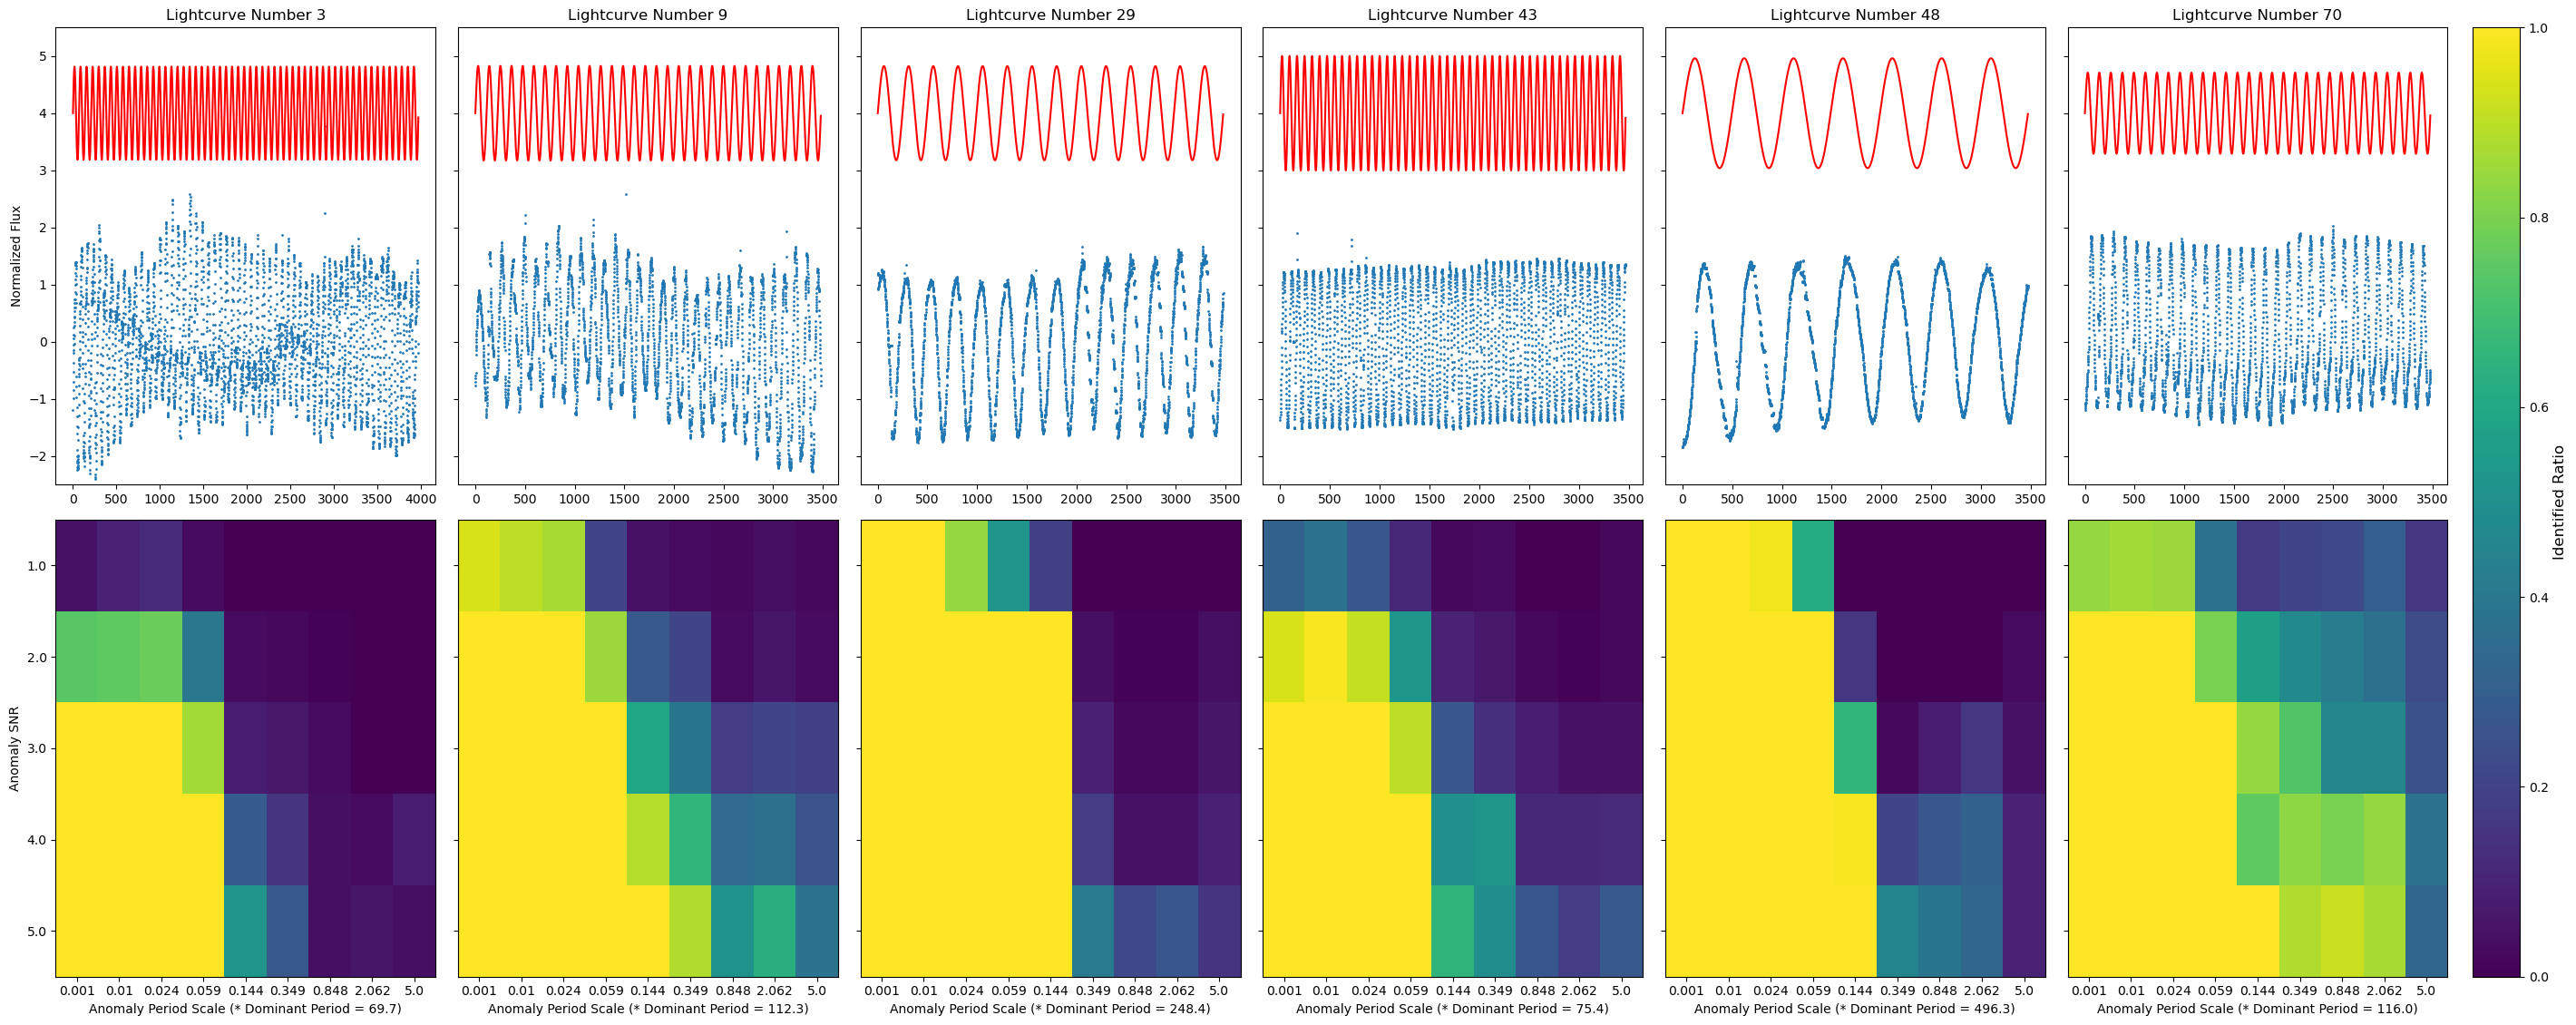

In [4]:
# Create figure
fig, axs = plt.subplots(2, 6, figsize=(28, 12))
for ax in axs.flat:
    ax.label_outer()

# Colorbar placeholder
im = None

# Colorbar min and max
vmin = grouped_periodic['identified_ratio'].min()
vmax = grouped_periodic['identified_ratio'].max()

# Plot each filename and location
for i, filename in enumerate(filenames_periodic):
    # Filter to only the current filename and label with filename
    filename_grouped = grouped_periodic[grouped_periodic['filename'] == filename]

    # Load the associated lightcurve
    k2_data_dir = '../data/k2/'
    k2_data_filename = f'k2_{short_filenames_periodic[i]}.fits'
    x, y, y_err = load_k2_data(k2_data_dir + k2_data_filename)

    # Create column that converts period_scale to actual value (multiply by the dominant period)
    freqs, power = periodogram(y)
    peaks, _ = find_peaks(power)
    if len(peaks) == 0:
        print("No peaks found in power spectrum, using shoulder instead")
        smooth_power = gaussian_filter1d(power, 2)
        slope = np.gradient(smooth_power, freqs)
        shoulder_idx = np.where(slope < 0)[0][0]
        dominant_period = 1 / freqs[shoulder_idx]
        
    else:
        dominant_peak = peaks[np.argmax(power[peaks])]
        dominant_period = 1 / freqs[dominant_peak]

    # Standardize data to have mean 0 and std of 1
    mean_y = np.mean(y)
    std_y = np.std(y)
    y = (y - mean_y) / std_y
    y_err = y_err / std_y

    # Plot lightcurve in axs[0, i]
    time_steps = np.arange(len(y))
    axs[0, i].plot(time_steps, y, '.', markersize=2, label='Raw Lightcurve (no anomaly injections)')
    axs[0, i].set_title(f"Lightcurve Number {short_filenames_periodic[i]}")

    # Above the lightcurve, plot a sinusoidal curve with the dominant period and amplitude 1 SNR
    snr = 1
    noise = np.median(np.abs(y - np.median(y)))
    amp = snr * noise
    y_sin = amp * np.sin(2 * np.pi * time_steps / dominant_period) + 4
    axs[0, i].plot(time_steps, y_sin, color='r', label='Dominant Period Sinusoid with Amplitude 1 SNR')

    # Show x-ticks and labels for every subplot
    axs[0, i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    axs[0, i].set_ylim([-2.5, 5.5])

    # Plot an imshow image colored by identified_ratio, x_axis is width_stdev, y_axis is amp
    pivot = filename_grouped.pivot(index='snr', columns='period_scale', values='identified_ratio')

    axs[1, i].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    axs[1, i].set_xlabel("Anomaly Period Scale (* Dominant Period = {:.1f})".format(dominant_period))
    axs[1, i].set_xticks(range(len(pivot.columns)), pivot.columns)
    axs[1, i].set_yticks(range(len(pivot.index)), pivot.index)

    if i==0: 
        axs[0, i].set_ylabel("Normalized Flux")
        axs[1, i].set_ylabel("Anomaly SNR")

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add a single colorbar to the right of the subplots for each row
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Identified Ratio', fontsize=12)

# Save and show the figure
plt.savefig(data_dir + data_name + "/periodic.png", bbox_inches='tight')
plt.show()

### Flat plot

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:240: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:240: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:240: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/scripts/../src/utils.py:240: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detec

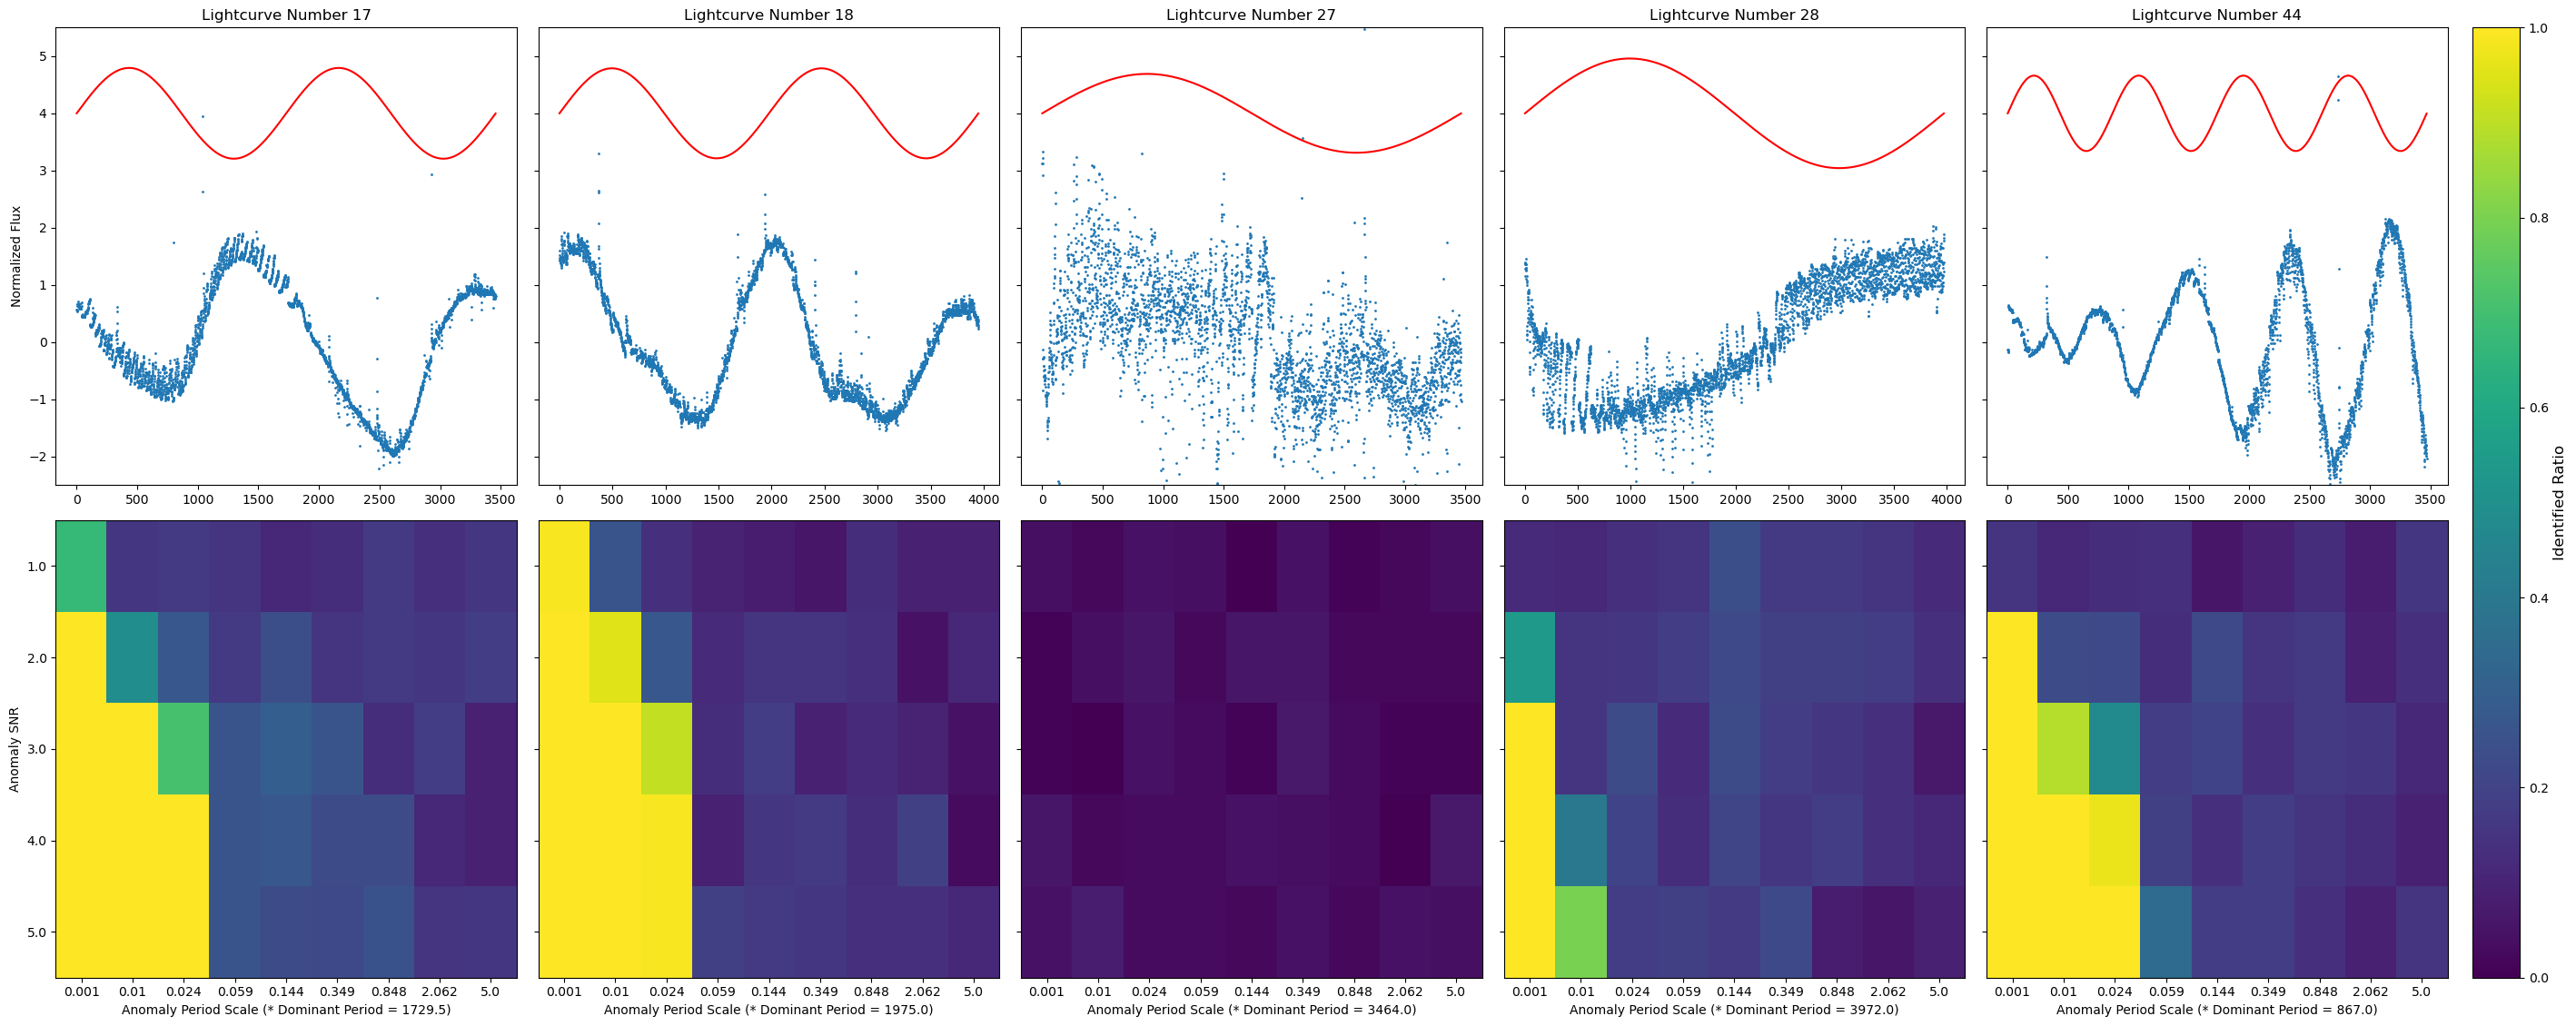

In [5]:
# Create figure
fig, axs = plt.subplots(2, 5, figsize=(28, 12))
# fig.suptitle("Ratio of Recovered Anomalies", fontsize=16)
for ax in axs.flat:
    ax.label_outer()

# Colorbar placeholder
im = None

# Colorbar min and max
vmin = grouped_flat['identified_ratio'].min()
vmax = grouped_flat['identified_ratio'].max()

# Plot each filename and location
for i, filename in enumerate(filenames_flat):
    # Filter to only the current filename and label with filename
    filename_grouped = grouped_flat[grouped_flat['filename'] == filename]

    # Load the associated lightcurve
    k2_data_dir = '../data/k2/'
    k2_data_filename = f'k2_{short_filenames_flat[i]}.fits'
    x, y, y_err = load_k2_data(k2_data_dir + k2_data_filename)

    # Create column that converts period_scale to actual value (multiply by the dominant period)
    freqs, power = periodogram(y)
    peaks, _ = find_peaks(power)
    if len(peaks) == 0:
        print("No peaks found in power spectrum, using shoulder instead")
        smooth_power = gaussian_filter1d(power, 2)
        slope = np.gradient(smooth_power, freqs)
        shoulder_idx = np.where(slope < 0)[0][0]
        dominant_period = 1 / freqs[shoulder_idx]
        
    else:
        dominant_peak = peaks[np.argmax(power[peaks])]
        dominant_period = 1 / freqs[dominant_peak]

    # Standardize data to have mean 0 and std of 1
    mean_y = np.mean(y)
    std_y = np.std(y)
    y = (y - mean_y) / std_y
    y_err = y_err / std_y

    # Plot lightcurve in axs[0, i]
    time_steps = np.arange(len(y))
    axs[0, i].plot(time_steps, y, '.', markersize=2, label='Raw Lightcurve (no anomaly injections)')
    axs[0, i].set_title(f"Lightcurve Number {short_filenames_flat[i]}")

    # Above the lightcurve, plot a sinusoidal curve with the dominant period and amplitude 1 SNR
    snr = 1
    noise = np.median(np.abs(y - np.median(y)))
    amp = snr * noise
    y_sin = amp * np.sin(2 * np.pi * time_steps / dominant_period) + 4
    axs[0, i].plot(time_steps, y_sin, color='r', label='Dominant Period Sinusoid with Amplitude 1 SNR')

    # Show x-ticks and labels for every subplot
    axs[0, i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    axs[0, i].set_ylim([-2.5, 5.5])

    # Plot an imshow image colored by identified_ratio, x_axis is width_stdev, y_axis is amp
    pivot = filename_grouped.pivot(index='snr', columns='period_scale', values='identified_ratio')

    axs[1, i].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto', vmin=vmin, vmax=vmax)
    axs[1, i].set_xlabel("Anomaly Period Scale (* Dominant Period = {:.1f})".format(dominant_period))
    axs[1, i].set_xticks(range(len(pivot.columns)), pivot.columns)
    axs[1, i].set_yticks(range(len(pivot.index)), pivot.index)

    if i==0: 
        axs[0, i].set_ylabel("Normalized Flux")
        axs[1, i].set_ylabel("Anomaly SNR")

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add a single colorbar to the right of the subplots for each row
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Identified Ratio', fontsize=12)

# Save and show the figure
plt.savefig(data_dir + data_name + "/flat.png", bbox_inches='tight')
plt.show()

## Varying size for single locs and files analysis
Particular injections sites and filenames, create 3x3 plot

In [44]:
data_dir = "../results/"
data_file = "gp_varying_anomaly_size_results.csv"

# Load data
results = pd.read_csv(data_dir + data_file)
results = results[results['location_idx'] != 2000]
results = results[results['location_idx'] != 3500]

# Get unique filenames and locations
filenames = results['filename'].unique()
short_filenames = [filename.split('k2_')[1].split('.fits')[0] for filename in filenames]
locations = results['location_idx'].unique()

# Print
print(filenames, short_filenames)
print(locations)
results.head()

['k2_3.fits' 'k2_18.fits' 'k2_48.fits'] ['3', '18', '48']
[ 500 1750 3000]


,filename,amp,width_stdev,shape,location_idx,flagged_anomalies,identified,identified_ratio
0,k2_3.fits,-4.0,14,gaussian,500,[ 455 456 457 458 459 460 461 462 463 ...,1.0,1.0
1,k2_3.fits,-5.0,2,gaussian,500,[ 480 481 482 483 484 485 486 487 488 ...,1.0,1.0
2,k2_3.fits,-4.0,2,gaussian,500,[ 490 491 492 493 494 495 496 497 498 ...,1.0,1.0
3,k2_3.fits,-3.0,2,gaussian,500,[ 492 493 494 495 496 497 498 499 500 ...,1.0,1.0
4,k2_3.fits,-2.0,2,gaussian,500,[ 492 493 494 495 496 497 498 499 500 ...,1.0,1.0


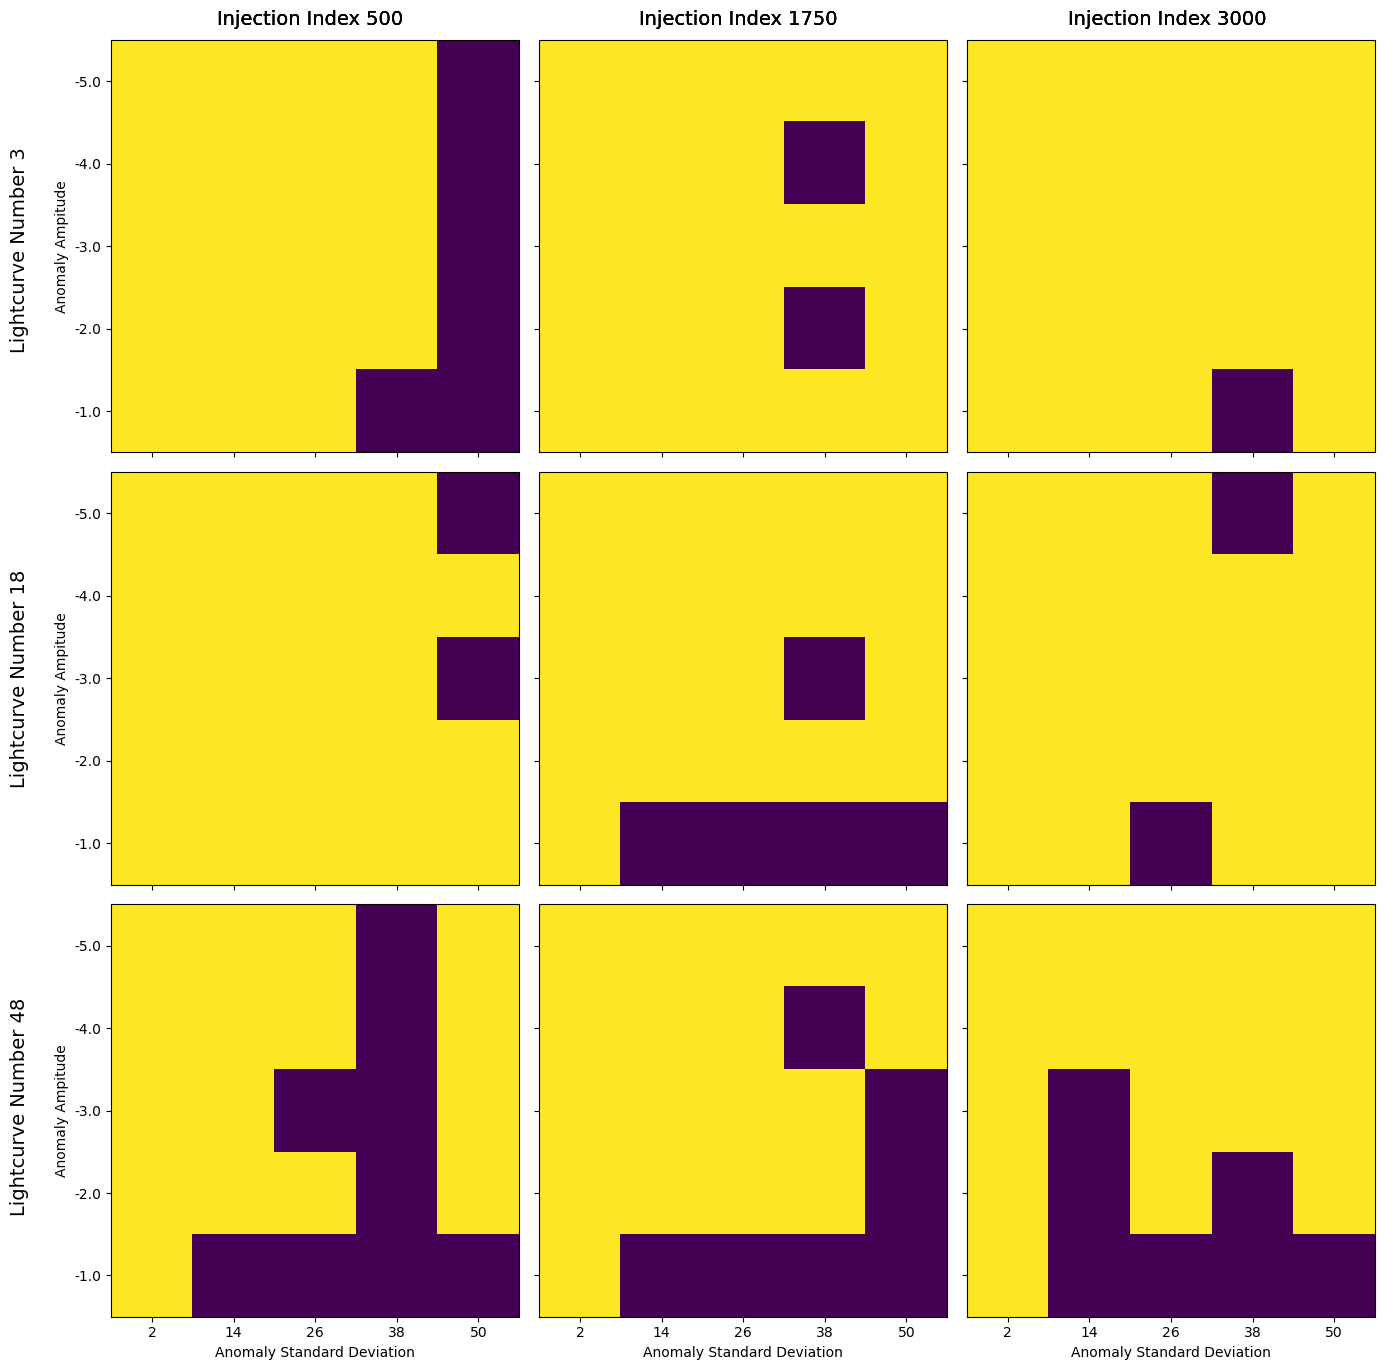

In [45]:
# Create figure
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
# fig.suptitle('Yellow: Anomaly Recovered, Purple: Anomaly Not Recovered', fontsize=16)
for ax in axs.flat:
    ax.label_outer()

# Plot each filename and location
for i, filename in enumerate(filenames):
    # Label the row and y axis of outer plot
    axs[i, 0].set_ylabel(f"Anomaly Ampitude")
    fig.text(0.03, 0.8 - i / 3.5, f"Lightcurve Number {short_filenames[i]}", va='center', rotation='vertical', fontsize=14)

    for j, location in enumerate(locations):
        # Label the column and x axis of outer plot
        axs[2, j].set_xlabel(f"Anomaly Standard Deviation")
        fig.text(0.23 + j / 3.5, 0.95, f"Injection Index {location}", ha='center', fontsize=14)

        current = results[results['filename'] == filename]
        current = current[current['location_idx'] == location]
        current = current.drop_duplicates(subset=['amp', 'width_stdev'])

        pivot = current.pivot(index='amp', columns='width_stdev', values='identified_ratio')
        axs[i, j].imshow(pivot, cmap='viridis', interpolation='nearest', aspect='auto')
        axs[i, j].set_xticks(range(len(pivot.columns)))
        axs[i, j].set_xticklabels(pivot.columns)
        axs[i, j].set_yticks(range(len(pivot.index)))
        axs[i, j].set_yticklabels(pivot.index)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.savefig(data_dir + data_name + ".png")
plt.show()